In [1]:
from IPython.display import Image

# YOLO
# You Only Look Once: Unified Real-Time Object Detection
---

## 0. Object Detection

- Object Detection이란 주어진 데이터(주로 이미지)에서 어떤 물체인지 분류(Classification)하고
그 물체의 위치 정보를 찾는(localization)을 동시에 하는 작업을 뜻한다.

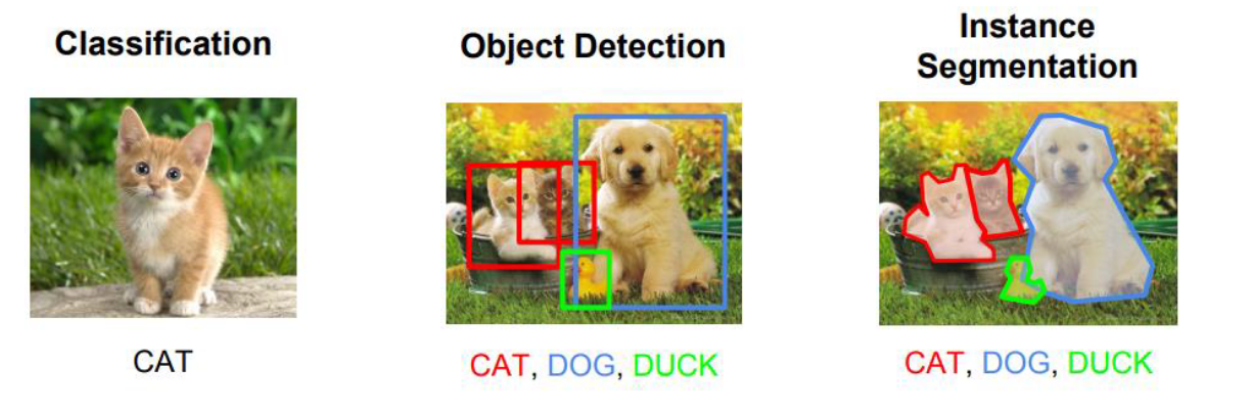

In [2]:
# 출처 cs231n 강의 자료
Image('img/01.png')

### 0.1 Previous Object Detection

Object detection survey paper : https://arxiv.org/pdf/1809.02165.pdf

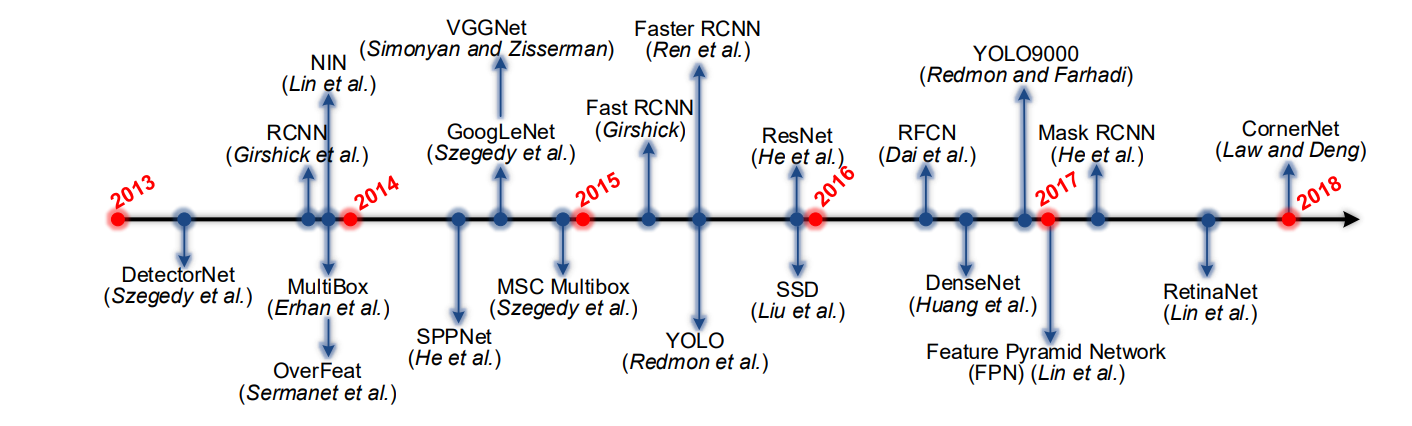

In [3]:
Image('img/02.png')

- Objective Detection Model은 크게 Two Stage detector와 One Stage detector로 나눌 수 있다.
- **Two stage detector**는 classification과 localization을 순차적으로 하는 모델을 뜻하고,
**One stage detector**는 두 문제를 동시에 행하는 모델을 뜻한다.

- 그러므로 One stage detector는 속도가 빠르고
Two stage detector는 속도가 느린대신 정확도가 비교적 높다.

---
### Two stage detector : RCNN
- 대표적인 Two stage detector인 RCNN은 총 5가지 단계로 Object를 찾는다.
    1. Region proposal
    2. Feature extraction
    3. classification
    4. Non-maximum Suppression
    5. Bounding box regression

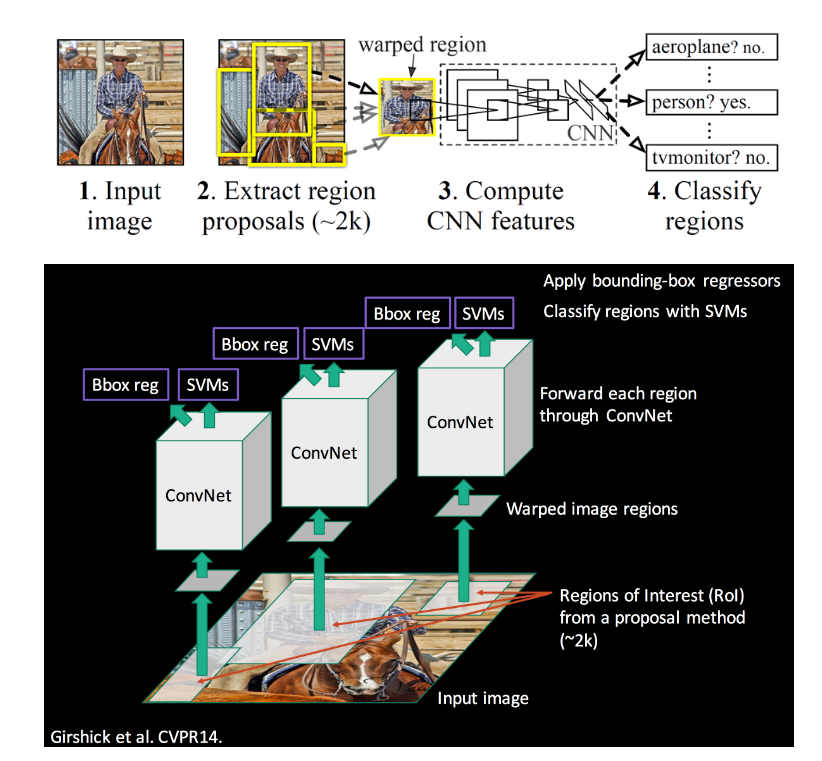

In [4]:
Image('img/03.png')

1. Region Proposal
    - Input Image에서 물체가 있을 법한 영역(Box)을 찾는 과정.
    - RCNN에서는 **Selective Search(SS)** 알고리즘을 이용하였으나, 이후 faster RCNN에서는 Neural Network가 이를 대체.
    - 대략 2000개의 영역을 뽑음.

2. Feature Extraction
    - 미리 학습된 CNN모델을 이용하여 각 box별 feature를 뽑아내는 과정.

3. Classification
    - 뽑아낸 feature들의 각각의 class를 분류하는 작업.
    - 결국 각각 box의 박스별로, 어떤 물체의 확률 값(score)을 가지게 됨.

4. Non-maximum Suppression
    - 같은 물체를 가르키는(예측한) box 제거하는 방법.
    - 같은 물체를 가르키는지 판단하기 위해 IoU(intersection over Union) 개념을 이용한다.
    - IoU값이 0.5이상인 경우 동일한 물체를 가르키고 있다고 판단하여 Score가 가장 높은 것을 제외하고 제거한다.

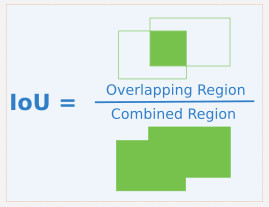

In [5]:
#IoU
Image('img/04.png')

5. Bounding Box regression
    - 1.에서 찾은 Box의 위치는 부정확하므로, regression을 통해 box의 위치를 교정시켜준다.
    - regression은 pool5 layer를 통과한 feature에 weight를 통과시켜 계산한다.

---

## 1. YOLO

### 1.1 Abstract

- YOLO는 기존의 object detection과 다른 새로운 접근 방식을 적용하였다.
- Seperated 된 bounding box의 regression과 class probability를 이용하여 접근하였다.
- 이미지 전체에 대해 하나의 신경망 한번의 계산으로 bounding box와 class probability를 예측한다.
- 빠르다. 1초에 45frame 정도 처리가 가능하다.

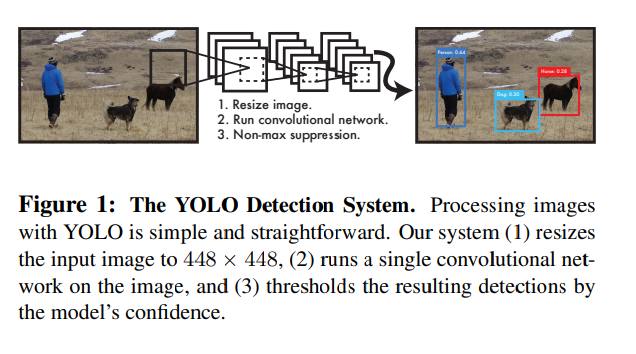

In [6]:
# yolo figure1
Image('img/05.png')

### 1.2 Unified Detection
**YOLO는 Object Detection의 개별 요소를 단일 신경망으로 통합한 모델**이다.
YOLO는 각 bounding box를 예측하기 위해, 전체 이미지의 feature를 사용한다.
이러한 디자인 덕분에 높은 정확성을 유지하면서 end to end 학습과 실시간 검출이 가능하다.

YOLO는 input image를 $S \times S$ grid로 나눈다.
만약 어떤 객체의 중심이 특정 grid cell 안에 위치한다면, 그 grid cell은 해당 객체를 검출해야 한다.

각각의 **grid cell**은 B개의 __bounding boxes__의 위치와 크기, 그리고 __confidence score__를 예측해야 한다.
또한 동시에 __conditional class probabilites(C)__를 예측하여야 한다.

- **bounding box**는 {$x, y, w, h, confidence$} 5개로 구성되어있다.
$(x,y)$는 grid cell에 대한 bounding box의 상대 중심 좌표를 뜻한다.
$(w,h)$는 전체이미지에 대한 bounding box의 상대 크기를 뜻한다.

- **confidence**는 $Pr(Object)* IOU^{truth}_{pred}$로 정의된다.
만약 cell에 object가 없다면 0이 나와야 하고, object가 있다면 IOU값과 동일한 값을 예측해야한다.

- **conditional class probabilites(C)**는 $Pr(Class_i|Object)$ 로 정의된다.

학습에서는 bounding box의 개수(B)와 상관없이 하나의 class만 예측하였지만,
test에서는 아래의 식을 통해, 각각의 box에 대한 class-specific confidence score로 예측하였다.

$$Pr(Class_i|Object)*Pr(Object)*IOU^{truth}_{pred} = Pr(Class_i)*IOU^{truth}_{pred}$$

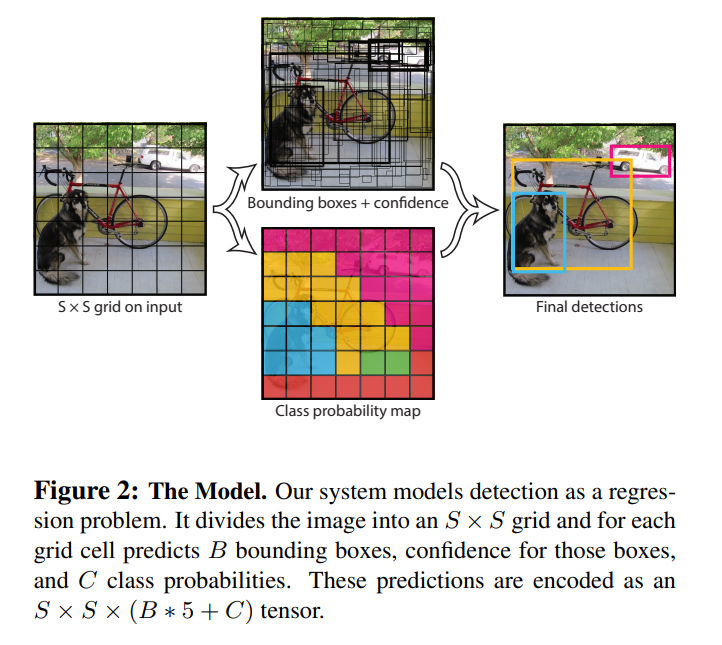

In [7]:
Image('img/06.png')

논문에서는 $S=7, B=2$로 설정하고, PASCAL VOC 데이터의 class의 개수 ($C=20$)로 최종적으로 $7 \times 7 \times 30$ tensor를 예측한다.

### 1.3 Network Design
Our network architecture is inspired by the __GoogLeNet__ model for image classification.
- 설명은 그림으로 대체하고 생략...

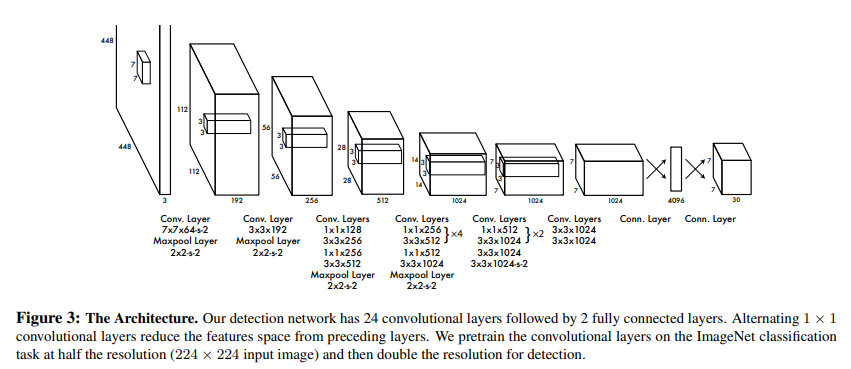

In [8]:
Image('img/07.png')

### 1.4 Training

1. Pretrain
    - ImageNet 데이터 셋으로 YOLO의 24개 계층중에서, 컨볼루션 20개의 계층을 이용 하여 pretrain을 시행.
    - 약 1주간 훈련하여, 88% 정확도의 네트워크를 사용

2. Resize Image
    - Object Detection을 위해서는 이미지의 해상도가 높아야 하므로 224x224에서 448x448로 증가시켜 사용.

3. 정규화 및 activation
    - x,y,w,h 값 모두 0~1 사이의 값으로 정규화 하였고, 마지막 계층은 선형 활성화 함수를 사용하고 나머지는 Leaky ReLU(a=0.1)을 사용.

4. Loss
    - Localization Error와 Classification Error의 weight를 같게 하는것은 이상적이지 않다.
    - 이미지에서 대부분의 grid cell에는 객체가 없기 때문에, 대부분의 grid cell은 confidence=0이 되도록 학습된다.
    이로인해 모델이 불안정 해 질 수 있다.
    - 이러한 이유로, bounding box의 x,y를 예측하는 것에는 loss값을 크게 하고,
    object가 없는 box의 confidence error는 낮게 설정한다.
    - $ \lambda_{coord} =5, \lambda_{no obj}=0.5$ 계수를 이용하여 조절한다.

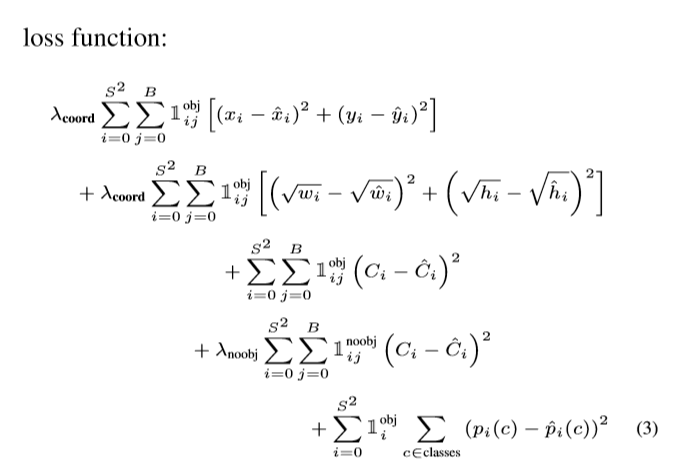

In [9]:
Image('img/08.png')

1. Object가 존재하는 그리드 셀에 대한 x,y loss
2. Object가 존재하는 그리드 셀에 대한 w,h loss. 큰 박스에 대해 작은 분산을 반영하기 위해, sum-squared error를 사용.
3. Object가 존재하는 그리드 셀에 대해 confidence loss를 계산
4. Object가 존재하지 않는 그리드 셀에 대해 confidence loss를 계산
5. Object가 존재하는 그리드 셀에 대해 class probability loss를 계산
